In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
from PIL import Image
from glob import glob
import pandas as pd

In [2]:
model = YOLO("best.pt")

In [3]:
model.names

{0: 'FFC',
 1: 'FFS',
 2: 'HCC',
 3: 'cyst',
 4: 'hemangioma',
 5: 'dysplastic',
 6: 'CCA'}

In [4]:
# path = glob("liver-ultrasound-detection/test/test/images/*")

In [5]:
# img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

In [6]:
# Image.fromarray(img)

In [29]:
test_path = "liver-ultrasound-detection/test/test/images/"
sample_submission = pd.read_csv("liver-ultrasound-detection/sample_submission.csv")

In [70]:
def xyxy_to_yolo(box):
    x_min, y_min, x_max, y_max = box
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min
    return center_x, center_y, width, height

def get_box(results):
    boxes = []
    confs = []
    pred = []
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            print(box)

            # center_x, center_y, width, height = xyxy_to_yolo([x1, y1, x2, y2])

            conf = box.conf[0]  # Extract confidence score
            cls = box.cls[0]  # Extract class label
            boxes.append([x for x in [x1, y1, x2, y2]])
            confs.append(conf.item())
            pred.append(int(cls.item()))
    
    decode = {
        "boxes": boxes,
        "confs": confs,
        "cls": pred
    }
    
    return decode

In [71]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (640, 640))
    # img = img / 255
    # img = np.transpose(img, (2, 0, 1))
    # img = np.expand_dims(img, 0)
    return img

In [72]:
def predict(path, idx):
    image_idx = sample_submission["Image File"][idx]
    path = test_path + str(image_idx) + ".jpg"
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = preprocess(img)
    
    results = model.predict(img, verbose=False)
    
    return {idx: get_box(results)}, {"image_idx": image_idx}

In [74]:
predict(test_path, 1)

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([4.], device='cuda:0')
conf: tensor([0.7292], device='cuda:0')
data: tensor([[200.6108, 205.5510, 322.0297, 313.5004,   0.7292,   4.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([1, 6])
xywh: tensor([[261.3203, 259.5257, 121.4188, 107.9493]], device='cuda:0')
xywhn: tensor([[0.4083, 0.4055, 0.1897, 0.1687]], device='cuda:0')
xyxy: tensor([[200.6108, 205.5510, 322.0297, 313.5004]], device='cuda:0')
xyxyn: tensor([[0.3135, 0.3212, 0.5032, 0.4898]], device='cuda:0')


({1: {'boxes': [[200.61083984375,
     205.55104064941406,
     322.0296630859375,
     313.5003662109375]],
   'confs': [0.7291500568389893],
   'cls': [4]}},
 {'image_idx': 102037})

In [24]:
import concurrent.futures
from tqdm import tqdm



lenght = len(sample_submission)
data = {}
with tqdm(range(lenght)) as pbar:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(predict, test_path, idx) for idx in range(lenght)]
        for future in concurrent.futures.as_completed(futures):
            results = future.result()
            for n, item in results[0].items():
                data[n] = item
            pbar.update()

data_sorted = dict(sorted(data.items()))

100%|██████████| 5153/5153 [02:21<00:00, 36.37it/s]


In [25]:
pred = []

for n, item in data_sorted.items():
    pred.append(item)

In [26]:
boxes = [i["boxes"] for i in pred]
confs = [i["confs"] for i in pred]
cls = [i["cls"] for i in pred]

In [27]:
len(boxes)

5153

In [30]:
sample_submission["Annotation"].loc[3:] = boxes[3:]
sample_submission["Label"].loc[3:] = cls[3:]

C:\Users\parwe\AppData\Local\Temp\ipykernel_1157740\1376976356.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sample_submission["Annotation"].loc[3:] = boxes[3:]
C:\Users\parwe\AppData\Local\Temp\ipykernel_1157740\1376976356.py:1: Setti

In [31]:
sample_submission.head(20)

,Image File,Annotation,Label
0,18999,"[[210.75, 245.33333333333334, 254.25, 354.6666...",[1]
1,102037,"[[197.25, 228.0, 269.25, 350.66666666666663]]",[4]
2,138340,"[[63.75, 313.33333333333326, 133.5, 444.0]]",[4]
3,140589,"[[352.08441162109375, 298.07415771484375, 41.7...",[4]
4,20235,"[[263.766357421875, 137.14498901367188, 36.647...",[1]
5,68271,[],[]
6,102209,"[[334.8651428222656, 298.6536865234375, 36.020...",[1]
7,77806,"[[281.75103759765625, 134.99191284179688, 96.4...",[2]
8,143255,[],[]
9,40700,"[[272.0230407714844, 165.64047241210938, 37.48...",[1]


In [32]:
sample_submission.to_csv("submission.csv", index=False)

In [170]:
image = cv2.imread("liver-ultrasound-detection/test/test/images/18999.jpg")
# image = preprocess(image)

x = model.predict(image, verbose=False)

In [139]:
x[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([3.], device='cuda:0')
conf: tensor([0.3671], device='cuda:0')
data: tensor([[3.2938e+02, 1.8110e+02, 5.3571e+02, 3.7571e+02, 3.6714e-01, 3.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (660, 880)
shape: torch.Size([1, 6])
xywh: tensor([[432.5431, 278.4058, 206.3254, 194.6145]], device='cuda:0')
xywhn: tensor([[0.4915, 0.4218, 0.2345, 0.2949]], device='cuda:0')
xyxy: tensor([[329.3804, 181.0986, 535.7058, 375.7131]], device='cuda:0')
xyxyn: tensor([[0.3743, 0.2744, 0.6088, 0.5693]], device='cuda:0')

In [140]:
def yoloFormattocv(x1, y1, x2, y2, H, W):
    bbox_width = x2 * W
    bbox_height = y2 * H
    center_x = x1 * W
    center_y = y1 * H
    voc = []
    voc.append(center_x - (bbox_width / 2))
    voc.append(center_y - (bbox_height / 2))
    voc.append(center_x + (bbox_width / 2))
    voc.append(center_y + (bbox_height / 2))
    return [int(v) for v in voc]

In [161]:
def draw_boxes(image, boxes, color=(0, 255, 0)):
    for box in boxes:
        x1, y1, x2, y2, _, _ = box
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

In [171]:
boxes = []
for result in x:
    for box in result.boxes:
        print(box.data)
        x, y, width, height, _, _ = box.data[0]
        print(box)
        conf = box.conf[0]
        cls = box.cls[0]
        boxes.append([x, y, width, height, conf.item(), int(cls.item())])

tensor([[3.2938e+02, 1.8110e+02, 5.3571e+02, 3.7571e+02, 3.6714e-01, 3.0000e+00]], device='cuda:0')
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([3.], device='cuda:0')
conf: tensor([0.3671], device='cuda:0')
data: tensor([[3.2938e+02, 1.8110e+02, 5.3571e+02, 3.7571e+02, 3.6714e-01, 3.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (660, 880)
shape: torch.Size([1, 6])
xywh: tensor([[432.5431, 278.4058, 206.3254, 194.6145]], device='cuda:0')
xywhn: tensor([[0.4915, 0.4218, 0.2345, 0.2949]], device='cuda:0')
xyxy: tensor([[329.3804, 181.0986, 535.7058, 375.7131]], device='cuda:0')
xyxyn: tensor([[0.3743, 0.2744, 0.6088, 0.5693]], device='cuda:0')


In [172]:
draw_boxes(image, boxes, (0, 255, 0))

In [173]:
draw_boxes(image, [[210.75, 245.33333333333334, 254.25, 354.6666666666667, 0, 0]], (255, 0, 0))

In [137]:
yoloFormattocv(210.75, 245.33333333333334, 254.25, 354.6666666666667, 640, 640)

[53732, 30395, 206055, 197906]

In [131]:
draw_boxes(image, [[53520, 43520, 216240, 270506, 0, 0]], (0, 0, 255))

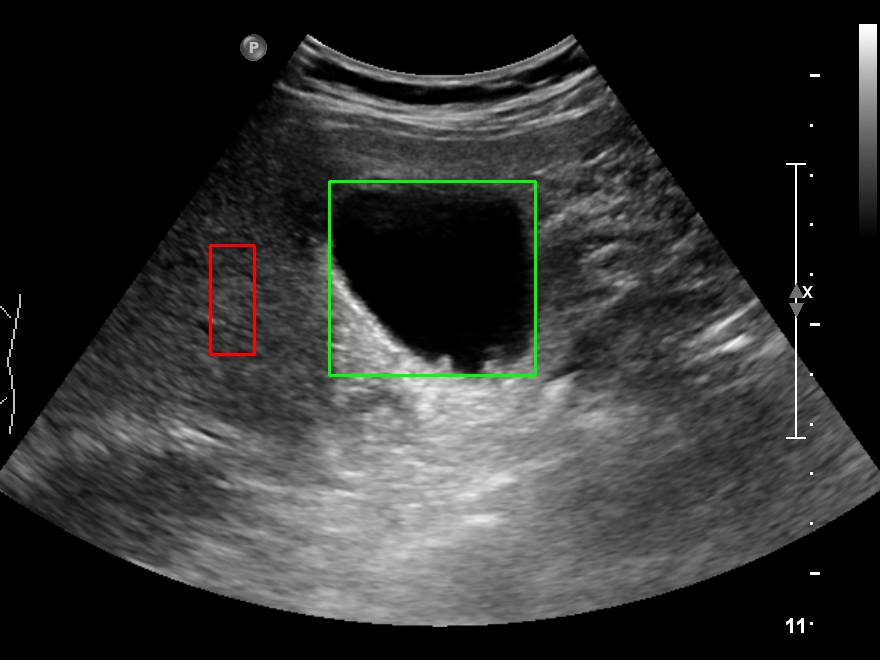

In [174]:
Image.fromarray(image)

In [37]:
import yaml

# Load dataset from YAML file
with open('eval.yaml', 'r') as file:
    eval = yaml.safe_load(file)

In [39]:
eval

{'path': '.',
 'val': './liver-ultrasound-detection/val/val',
 'names': {0: 'FFC',
  1: 'FFS',
  2: 'HCC',
  3: 'cyst',
  4: 'hemangioma',
  5: 'dysplastic',
  6: 'CCA'}}

In [43]:
results = []
for item in eval:

    print(item)
    # break
    # # Read image
    # image = cv2.imread(image_path)

    # # Perform inference
    # result = model(image)

    # # Optionally, compare the result with ground truth annotation to calculate evaluation metrics
    # # You can use libraries like pycocotools or mAP to calculate metrics

    # results.append(result)

path
val
names


In [44]:
x = [240.6450653076172, 107.35041809082031, 156.22145080566406, 349.01658630371094]

In [45]:
def yolo_to_cv2(box):
    center_x, center_y, width, height = box
    x_min = int(center_x - width / 2)
    y_min = int(center_y - height / 2)
    x_max = int(center_x + width / 2)
    y_max = int(center_y + height / 2)
    return x_min, y_min, x_max, y_max

In [46]:
x = yolo_to_cv2(x)

In [49]:
img = cv2.imread(test_path + "91149.jpg", cv2.IMREAD_UNCHANGED)
img = preprocess(img)

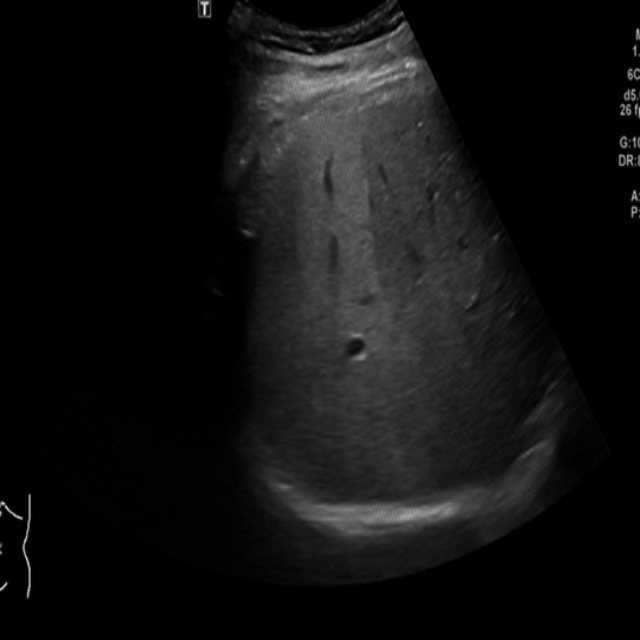

In [50]:
Image.fromarray(img)

In [51]:
boxes[0]

[[202.95941162109375, 178.36050415039062, 35.0445556640625, 83.37542724609375]]